In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torchsummary import summary
import matplotlib.pyplot as plt
import numpy as np
from sklearn.manifold import TSNE
import os
import torchvision.models as models
from record_utils import RecordManager
from models import TriggerSensitiveVGG


LOAD_OLD_MODEL = False 

BATCH_SIZE = 128
EPOCHS = 20
TEST_BATCH_SIZE = 64
VIZ_BATCH_SIZE = 5

CHECKPOINT_PATH = "./checkpoints/cifar/checkpoint_1.0pth"
CHECKPOINT_FOLDER_PATH = "./models/cifar10"

CIFAR10_CLASSES = {
    0: "airplane",
    1: "automobile",
    2: "bird",
    3: "cat",
    4: "deer",
    5: "dog",
    6: "frog",
    7: "horse",
    8: "ship",
    9: "truck"
}

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


In [2]:
# Load CIFAR-10 dataset
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),  # Normalize to mean=0.5, std=0.5 for each channel
    transforms.RandomHorizontalFlip(),
])

train_dataset = torchvision.datasets.CIFAR10(root='./data', train=True, download=False, transform=transform)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)

test_dataset = torchvision.datasets.CIFAR10(root='./data', train=False, download=False, transform=transform)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=TEST_BATCH_SIZE, shuffle=False)

viz_loader = torch.utils.data.DataLoader(test_dataset, batch_size=VIZ_BATCH_SIZE, shuffle=False)

In [3]:
print("Train size:",len(train_loader.dataset))
print("Test size:",len(test_loader.dataset))

from collections import defaultdict 
class_counts = defaultdict(int)

# Iterate through the test_loader
for _, labels in test_loader:
    for label in labels:
        class_counts[label.item()] += 1

# Print counts per class
for class_idx, count in class_counts.items():
    print(f"Class {class_idx}: {count} samples")

Train size: 50000
Test size: 10000
Class 3: 1000 samples
Class 8: 1000 samples
Class 0: 1000 samples
Class 6: 1000 samples
Class 1: 1000 samples
Class 9: 1000 samples
Class 5: 1000 samples
Class 7: 1000 samples
Class 4: 1000 samples
Class 2: 1000 samples


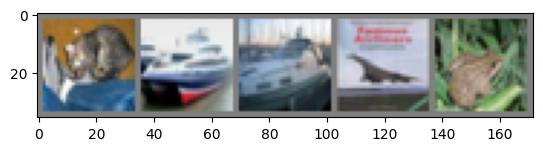

  cat  ship  ship airplane  frog


In [4]:
def imshow(img):
    img = img / 2 + 0.5  # Unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

# Get some random training images
dataiter = iter(viz_loader)
images, labels = dataiter.__next__()

# Show images
imshow(torchvision.utils.make_grid(images))
print(' '.join('%5s' % train_dataset.classes[labels[j]] for j in range(VIZ_BATCH_SIZE)))

In [5]:
model = TriggerSensitiveVGG().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001, weight_decay=0.001)
record_manager = RecordManager(CHECKPOINT_FOLDER_PATH)

#Load state dict
if LOAD_OLD_MODEL:
    checkpoint = torch.load('./checkpoints/cifar/checkpoint_4.1.pth')
    model.load_state_dict(checkpoint['model_state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    optimizer = torch.optim.Adam(model.parameters(), weight_decay=0.01)

best_test_accuracy = 0.0

for epoch in range(EPOCHS):
    model.train()
    running_loss = 0.0
    total_correct = 0
    total_samples = 0
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = outputs.max(1)
        total_correct += predicted.eq(labels).sum().item()
        total_samples += labels.size(0)
    accuracy = total_correct / total_samples

    print(f"Epoch {epoch+1}/{EPOCHS}, Loss: {running_loss/len(train_loader)}, Accuracy: {accuracy}")
    total_correct = 0
    total_samples = 0
    model.eval()
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        _, predicted = outputs.max(1)
        total_correct += predicted.eq(labels).sum().item()
        total_samples += labels.size(0)
    test_accuracy = total_correct / total_samples
    if test_accuracy > 0.8 and test_accuracy > best_test_accuracy: 
        record_manager.save_checkpoint(model, optimizer,running_loss, epoch, test_accuracy=test_accuracy,train_accuracy=accuracy)
        best_test_accuracy = test_accuracy
    else:
        record_manager.save_metrics(running_loss, epoch, train_accuracy=accuracy, test_accuracy=test_accuracy)            
    print(f"    Test Accuracy: {test_accuracy:.4f}") 

Epoch 1/20, Loss: 0.629288332312918, Accuracy: 0.78158
Checkpoint saved to: ./models/cifar10\run11\checkpoints\checkpoint_1.1tacc_0.8300.pth
Accuracies updated in: ./models/cifar10\run11\accuracies\all_accuracies.json
    Test Accuracy: 0.8300
Epoch 2/20, Loss: 0.368061411296925, Accuracy: 0.87426
Checkpoint saved to: ./models/cifar10\run11\checkpoints\checkpoint_1.2tacc_0.8640.pth
Accuracies updated in: ./models/cifar10\run11\accuracies\all_accuracies.json
    Test Accuracy: 0.8640
Epoch 3/20, Loss: 0.2759161194229065, Accuracy: 0.90504
Checkpoint saved to: ./models/cifar10\run11\checkpoints\checkpoint_1.3tacc_0.8697.pth
Accuracies updated in: ./models/cifar10\run11\accuracies\all_accuracies.json
    Test Accuracy: 0.8697
Epoch 4/20, Loss: 0.21890601041295643, Accuracy: 0.92392
Checkpoint saved to: ./models/cifar10\run11\checkpoints\checkpoint_1.4tacc_0.8733.pth
Accuracies updated in: ./models/cifar10\run11\accuracies\all_accuracies.json
    Test Accuracy: 0.8733
Epoch 5/20, Loss: 0.1

In [6]:
import seaborn as sns

def get_latent_features(model, data_loader, layer_name):
    model.eval()
    intermediate_outputs = []
    all_labels = []

    # Register a forward hook to capture the intermediate layer's output
    def hook(module, input, output):
        intermediate_outputs.append(output.cpu().numpy())

    hook_handler = model._modules[layer_name].register_forward_hook(hook)

    with torch.no_grad():
        for inputs, labels in data_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            _ = model(inputs)  # Trigger the forward pass to collect the intermediate features
            all_labels.append(labels.cpu().numpy())

    hook_handler.remove()  # Remove the hook to avoid affecting subsequent forward passes

    return np.concatenate(intermediate_outputs), np.concatenate(all_labels)


# Choose an intermediate layer for t-SNE visualization
intermediate_layer_name = 'fc3'  #You can change this to the desired layer

# Get latent features and labels from the specified intermediate layer
features, labels = get_latent_features(model, test_loader, intermediate_layer_name)

# Reshape the features if needed (e.g., flatten for fully connected layers)
if len(features.shape) > 2:
    features = features.reshape(features.shape[0], -1)

# Use t-SNE for dimensionality reduction
tsne = TSNE(n_components=2, random_state=42)
latent_tsne = tsne.fit_transform(features)

# Plot t-SNE visualization
sns.set(style="whitegrid")
plt.figure(figsize=(10, 8))
scatter = sns.scatterplot(x=latent_tsne[:, 0], y=latent_tsne[:, 1], hue=labels, palette="tab10", legend="full")
scatter.set_title(f"t-SNE Visualization of Latent Features from {intermediate_layer_name}")
plt.show()

KeyError: 'fc3'

In [ ]:
from sklearn.manifold import TSNE

def visualize_tsne(model, test_loader, device):
    model.to(device)
    model.eval()

    # Lists to store features and labels
    features = []
    labels = []
    true_labels = []
    poisoned_flags = []

    # Extract features and labels
    with torch.no_grad():
        for batch in test_loader:
            images, labels_batch, true_labels_batch, poisoned_batch = batch
            images = images.to(device)

            # Extract features
            feats = model.extract_features(images)
            features.append(feats.cpu().numpy())
            labels.append(labels_batch.numpy())
            true_labels.append(true_labels_batch.numpy())
            poisoned_flags.append(poisoned_batch.numpy())

    # Concatenate all features and labels
    features = np.concatenate(features, axis=0)
    labels = np.concatenate(labels, axis=0)
    true_labels = np.concatenate(true_labels, axis=0)
    poisoned_flags = np.concatenate(poisoned_flags, axis=0)

    # Apply t-SNE
    tsne = TSNE(n_components=2, random_state=42)
    features_2d = tsne.fit_transform(features)

    # Create a scatter plot
    plt.figure(figsize=(12, 8))
    for is_poisoned in [0, 1]:
        mask = poisoned_flags == is_poisoned
        plt.scatter(features_2d[mask, 0], features_2d[mask, 1],
                    label=f"{'Poisoned' if is_poisoned else 'Clean'}", alpha=0.7)

    plt.legend()
    plt.title("t-SNE Visualization of Extracted Features")
    plt.xlabel("t-SNE Dimension 1")
    plt.ylabel("t-SNE Dimension 2")
    plt.grid(True)
    plt.show()